# Task: Software Defect Prediction via Convolutional Neural Network
## Mô tả bài toán
Dựa vào paper IEEE 2017 - DP-CNN đề xuất 1 phuơng pháp mới, DP-CNN (Defect Prediction via Convolutional Neural Network) là một phương pháp dự đoán lỗi phần mềm bằng cách kết hợp học sâu với các đặc trưng truyền thống. Thay vì chỉ dựa vào các đặc trưng thủ công như độ phức tạp mã nguồn, DP-CNN tự động học đặc trưng ngữ nghĩa và cấu trúc từ cây Cú pháp Trừu tượng (AST) bằng CNN, sau đó kết hợp với các đặc trưng truyền thống để cải thiện độ chính xác.
## Phương pháp đề xuất
1️⃣ Phân tích mã nguồn thành cây AST, trích xuất token quan trọng.

2️⃣ Mã hóa token thành vector số bằng kỹ thuật word embedding.

3️⃣ Sử dụng CNN để học đặc trưng ngữ nghĩa và cấu trúc từ mã nguồn.

4️⃣ Kết hợp với đặc trưng truyền thống để tối ưu dự đoán.

5️⃣ Huấn luyện mô hình và phân loại file là "có lỗi" hoặc "không lỗi".

# 1. Phân tích dữ liệu

- Dự kiến: Lấy tập Ant-1.6 để trainning và tập Ant-1.7 để test1
- Tải bộ source code của bộ Ant-1.6 và Ant-1.7 từ archive.apache.org.
- Đọc dữ liệu csv chứa thông tin về các đặc trưng truyền thống về phần mềm và label cho biết code lỗi hay không
- Lọc chỉ lấy những file source code có trong file csv đã phân tích

In [116]:
!wget https://archive.apache.org/dist/ant/source/apache-ant-1.6.0-src.tar.gz
!tar -xvzf apache-ant-1.6.0-src.tar.gz

!wget https://archive.apache.org/dist/ant/source/apache-ant-1.7.0-src.tar.gz
!tar -xvzf apache-ant-1.7.0-src.tar.gz


--2025-03-16 13:47:44--  https://archive.apache.org/dist/ant/source/apache-ant-1.6.0-src.tar.gz
Resolving archive.apache.org (archive.apache.org)... 65.108.204.189, 2a01:4f9:1a:a084::2
Connecting to archive.apache.org (archive.apache.org)|65.108.204.189|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7029218 (6.7M) [application/x-gzip]
Saving to: ‘apache-ant-1.6.0-src.tar.gz.3’

apache-ant-1.6.0-sr 100%[===================>]   6.70M  5.80MB/s    in 1.2s    

2025-03-16 13:47:45 (5.80 MB/s) - ‘apache-ant-1.6.0-src.tar.gz.3’ saved [7029218/7029218]

apache-ant-1.6.0/bootstrap.sh
apache-ant-1.6.0/build.sh
apache-ant-1.6.0/
apache-ant-1.6.0/docs/
apache-ant-1.6.0/docs/ant2/
apache-ant-1.6.0/docs/images/
apache-ant-1.6.0/docs/manual/
apache-ant-1.6.0/docs/manual/CoreTasks/
apache-ant-1.6.0/docs/manual/CoreTypes/
apache-ant-1.6.0/docs/manual/Integration/
apache-ant-1.6.0/docs/manual/OptionalTasks/
apache-ant-1.6.0/docs/manual/OptionalTypes/
apache-ant-1.6.0/docs/man

In [117]:
import os
import pandas as pd
from google.colab import drive

drive.mount('/content/drive')

train_csv_path = "/content/drive/MyDrive/Colab Notebooks/NLP/Task DP-CNN/ant-1.6.csv"
test_csv_path = "/content/drive/MyDrive/Colab Notebooks/NLP/Task DP-CNN/ant-1.7.csv"

train_csv = pd.read_csv(train_csv_path)
test_csv = pd.read_csv(test_csv_path)

# Chuẩn hóa tên file từ CSV để phù hợp với thư mục tools/
def convert_csv_name_to_java_filename(csv_name):
    """
    Chuyển:
    'org.apache.tools.ant.taskdefs.Property'  → 'ant/taskdefs/Property.java'
    'org.apache.tools.mail.MailLogger'        → 'mail/MailLogger.java'

    Cách làm:
    - Tìm 'tools.' trong đường dẫn, lấy phần sau nó làm thư mục gốc.
    - Nếu không có 'tools.', giữ nguyên.
    """
    parts = csv_name.split('.')
    if 'tools' in parts:
        index = parts.index('tools') + 1  # Lấy phần sau 'tools'
        return "/".join(parts[index:]) + ".java"
    return csv_name + ".java"

# Lấy danh sách file Java từ CSV (giữ đúng tầng thư mục `ant/`, `mail/`...)
train_csv_files = set(train_csv['name'].apply(convert_csv_name_to_java_filename))
test_csv_files = set(test_csv['name'].apply(convert_csv_name_to_java_filename))

# Hàm lấy tất cả file Java trong thư mục mã nguồn (bao gồm tất cả thư mục con trong tools/)
def get_all_java_files(directory):
    """Lấy tất cả file Java trong thư mục tools/ (bao gồm cả ant/, mail/, ...)"""
    java_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(".java"):
                java_files.append(os.path.join(root, file))
    return java_files

# Đường dẫn đến mã nguồn Apache Ant (lấy toàn bộ tools/)
train_dir = "apache-ant-1.6.0/src/main/org/apache/tools"
test_dir = "apache-ant-1.7.0/src/main/org/apache/tools"

# Lấy tất cả file Java từ thư mục mã nguồn
train_files_all = get_all_java_files(train_dir)
test_files_all = get_all_java_files(test_dir)

# Chuyển đường dẫn file Java thành dạng để so sánh với CSV
def convert_java_path_to_filename(java_path, base_dir):
    """Chuyển đường dẫn file Java thành tên tương đương trong CSV"""
    relative_path = os.path.relpath(java_path, base_dir)  # Lấy đường dẫn tương đối
    return relative_path.replace("\\", "/")  # Đảm bảo dạng Linux-style path

# Tạo danh sách file từ mã nguồn ở dạng `ant/taskdefs/Property.java`
train_files_as_java = {convert_java_path_to_filename(f, train_dir) for f in train_files_all}
test_files_as_java = {convert_java_path_to_filename(f, test_dir) for f in test_files_all}

# Kiểm tra số lượng file khớp giữa CSV và mã nguồn
matched_train_files = train_files_as_java.intersection(train_csv_files)
matched_test_files = test_files_as_java.intersection(test_csv_files)

print(f"Số file trong CSV (Ant 1.6): {len(train_csv_files)}")
print(f"Số file có trong mã nguồn Ant 1.6: {len(train_files_all)}")
print(f"Số file trùng khớp giữa CSV và mã nguồn Ant 1.6: {len(matched_train_files)}")

print(f"Số file trong CSV (Ant 1.7): {len(test_csv_files)}")
print(f"Số file có trong mã nguồn Ant 1.7: {len(test_files_all)}")
print(f"Số file trùng khớp giữa CSV và mã nguồn Ant 1.7: {len(matched_test_files)}")

# Chỉ giữ lại các file Java có trong CSV
def get_java_files_by_csv(directory, csv_files):
    """Chỉ lấy file Java có trong danh sách CSV"""
    matched_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            full_path = os.path.join(root, file)
            relative_path = convert_java_path_to_filename(full_path, directory)
            if relative_path in csv_files:
                matched_files.append(full_path)
    return matched_files

filtered_train_files = get_java_files_by_csv(train_dir, matched_train_files)
filtered_test_files = get_java_files_by_csv(test_dir, matched_test_files)

print(f"Số file Java sau khi lọc theo CSV (Ant 1.6): {len(filtered_train_files)}")
print(f"Số file Java sau khi lọc theo CSV (Ant 1.7): {len(filtered_test_files)}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Số file trong CSV (Ant 1.6): 351
Số file có trong mã nguồn Ant 1.6: 742
Số file trùng khớp giữa CSV và mã nguồn Ant 1.6: 350
Số file trong CSV (Ant 1.7): 745
Số file có trong mã nguồn Ant 1.7: 778
Số file trùng khớp giữa CSV và mã nguồn Ant 1.7: 741
Số file Java sau khi lọc theo CSV (Ant 1.6): 350
Số file Java sau khi lọc theo CSV (Ant 1.7): 741


In [118]:
# Lấy danh sách file Java từ CSV (dạng chuẩn hóa)
csv_train_files = set(train_csv['name'].apply(convert_csv_name_to_java_filename))
csv_test_files = set(test_csv['name'].apply(convert_csv_name_to_java_filename))

# Lấy danh sách file Java thực tế trong source code (dạng chuẩn hóa)
source_train_files = {convert_java_path_to_filename(f, train_dir) for f in train_files_all}
source_test_files = {convert_java_path_to_filename(f, test_dir) for f in test_files_all}

# Tìm file có trong CSV nhưng không có trong Source Code
missing_train_files = csv_train_files - source_train_files
missing_test_files = csv_test_files - source_test_files

print(f"Số file có trong CSV nhưng không có trong Source Code (Ant 1.6): {len(missing_train_files)}")
print(f"Số file có trong CSV nhưng không có trong Source Code (Ant 1.7): {len(missing_test_files)}")

# Hiển thị 10 file đầu tiên bị thiếu
print("Các file bị thiếu trong Ant 1.6:", list(missing_train_files)[:10])
print("Các file bị thiếu trong Ant 1.7:", list(missing_test_files)[:10])


Số file có trong CSV nhưng không có trong Source Code (Ant 1.6): 1
Số file có trong CSV nhưng không có trong Source Code (Ant 1.7): 4
Các file bị thiếu trong Ant 1.6: ['mail/MailPrintStream.java']
Các file bị thiếu trong Ant 1.7: ['ant/taskdefs/optional/jlink/ConstantPool.java', 'ant/taskdefs/optional/junit/CompoundEnumeration.java', 'mail/MailPrintStream.java', 'ant/taskdefs/optional/junit/ArrayEnumeration.java']


In [119]:
# 🔹 1. Lọc lại DataFrame chỉ giữ các file có trong Source Code
filtered_train_csv = train_csv[train_csv['name'].apply(convert_csv_name_to_java_filename).isin(matched_train_files)]
filtered_test_csv = test_csv[test_csv['name'].apply(convert_csv_name_to_java_filename).isin(matched_test_files)]

# 🔹 2. Lưu lại CSV mới chỉ chứa các file có trong Source Code
filtered_train_csv_path = "/content/drive/MyDrive/Colab Notebooks/NLP/Task DP-CNN/filtered_ant-1.6.csv"
filtered_test_csv_path = "/content/drive/MyDrive/Colab Notebooks/NLP/Task DP-CNN/filtered_ant-1.7.csv"

filtered_train_csv.to_csv(filtered_train_csv_path, index=False)
filtered_test_csv.to_csv(filtered_test_csv_path, index=False)

print(f"File CSV mới đã được lưu: {filtered_train_csv_path}")
print(f"File CSV mới đã được lưu: {filtered_test_csv_path}")

# Đọc dữ liệu từ file CSV mới
filtered_train_df = pd.read_csv(filtered_train_csv_path)
filtered_test_df = pd.read_csv(filtered_test_csv_path)

# In số lượng file còn lại sau khi lọc
print(f"Số lượng file còn lại trong CSV mới (Ant 1.6): {filtered_train_df.shape[0]}")
print(f"Số lượng file còn lại trong CSV mới (Ant 1.7): {filtered_test_df.shape[0]}")



File CSV mới đã được lưu: /content/drive/MyDrive/Colab Notebooks/NLP/Task DP-CNN/filtered_ant-1.6.csv
File CSV mới đã được lưu: /content/drive/MyDrive/Colab Notebooks/NLP/Task DP-CNN/filtered_ant-1.7.csv
Số lượng file còn lại trong CSV mới (Ant 1.6): 350
Số lượng file còn lại trong CSV mới (Ant 1.7): 741


## Visualization và tiền xử lí dữ liệu


In [120]:
# Chuyển đổi label: Nếu bug >= 1 thì gán thành 1, ngược lại giữ nguyên
filtered_train_df['bug'] = filtered_train_df['bug'].apply(lambda x: 1 if x >= 1 else 0)
filtered_test_df['bug'] = filtered_test_df['bug'].apply(lambda x: 1 if x >= 1 else 0)

# Kiểm tra lại số lượng mẫu sau khi chuẩn hóa
print("📌 Số lượng mỗi lớp sau khi xử lý trong tập train:")
print(filtered_train_df['bug'].value_counts())

print("\n📌 Số lượng mỗi lớp sau khi xử lý trong tập test:")
print(filtered_test_df['bug'].value_counts())

# Lưu tập train & test mới sau khi chuẩn hóa
filtered_train_csv_path = "/content/drive/MyDrive/Colab Notebooks/NLP/Task DP-CNN/normalized_ant-1.6.csv"
filtered_test_csv_path = "/content/drive/MyDrive/Colab Notebooks/NLP/Task DP-CNN/normalized_ant-1.7.csv"

filtered_train_df.to_csv(filtered_train_csv_path, index=False)
filtered_test_df.to_csv(filtered_test_csv_path, index=False)

print(f"Dữ liệu đã được chuẩn hóa và lưu tại: {filtered_train_csv_path}")
print(f"Dữ liệu đã được chuẩn hóa và lưu tại: {filtered_test_csv_path}")


📌 Số lượng mỗi lớp sau khi xử lý trong tập train:
bug
0    258
1     92
Name: count, dtype: int64

📌 Số lượng mỗi lớp sau khi xử lý trong tập test:
bug
0    575
1    166
Name: count, dtype: int64
Dữ liệu đã được chuẩn hóa và lưu tại: /content/drive/MyDrive/Colab Notebooks/NLP/Task DP-CNN/normalized_ant-1.6.csv
Dữ liệu đã được chuẩn hóa và lưu tại: /content/drive/MyDrive/Colab Notebooks/NLP/Task DP-CNN/normalized_ant-1.7.csv


Số lượng file không lỗi (bug=0): 258
Số lượng file có lỗi (bug=1): 92


<ipython-input-121-9240fb5cc437>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=bug_counts.index, y=bug_counts.values, palette="viridis")


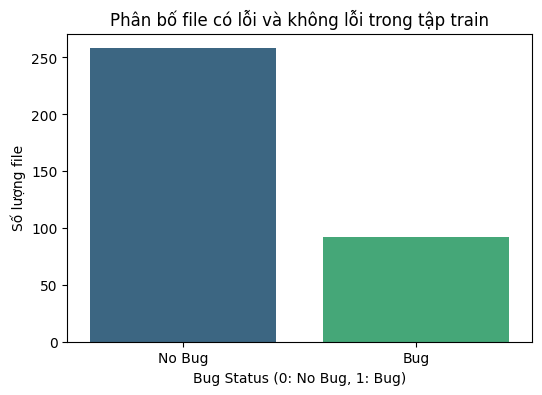

In [121]:
import matplotlib.pyplot as plt
import seaborn as sns

# Kiểm tra số lượng mẫu trong từng lớp (có lỗi và không lỗi)
bug_counts = filtered_train_df['bug'].value_counts()
print("Số lượng file không lỗi (bug=0):", bug_counts[0])
print("Số lượng file có lỗi (bug=1):", bug_counts[1])

# Vẽ biểu đồ
plt.figure(figsize=(6,4))
sns.barplot(x=bug_counts.index, y=bug_counts.values, palette="viridis")
plt.xlabel("Bug Status (0: No Bug, 1: Bug)")
plt.ylabel("Số lượng file")
plt.title("Phân bố file có lỗi và không lỗi trong tập train")
plt.xticks(ticks=[0, 1], labels=["No Bug", "Bug"])
plt.show()


Nhận thấy dữ liệu Bug đang mất cân bằng so với dữ liệu No bug, nhân đôi các instance từ lớp

In [145]:
# Lấy các mẫu thuộc lớp bug=1
bug_class = filtered_train_df[filtered_train_df['bug'] == 1]

# Nhân đôi số lượng mẫu của lớp bug=1
duplicated_bug_class = pd.concat([bug_class, bug_class])

# Ghép lại với lớp bug=0 nhưng không trộn lẫn dữ liệu
balanced_train_df = pd.concat([filtered_train_df[filtered_train_df['bug'] == 0], duplicated_bug_class])

# Reset index sau khi nhân đôi
balanced_train_df = balanced_train_df.reset_index(drop=True)
filtered_train_df = balanced_train_df
# Kiểm tra kết quả
print(f"Số lượng file trong tập train sau cân bằng:\n{balanced_train_df['bug'].value_counts()}")


Số lượng file trong tập train sau cân bằng:
bug
0    258
1    184
Name: count, dtype: int64


In [123]:
# 🔹 1. Chuẩn hóa danh sách file bug=1 từ CSV để khớp với source code
bug_files_csv = set(filtered_train_df[filtered_train_df['bug'] == 1]['name'].apply(convert_csv_name_to_java_filename))

# 🔹 2. Chuẩn hóa danh sách file từ source code để có dạng giống CSV
source_files_formatted = set(convert_java_path_to_filename(f, train_dir) for f in filtered_train_files)

# 🔹 3. Kiểm tra file có trong CSV nhưng không tìm thấy trong source code
missing_files = bug_files_csv - source_files_formatted
extra_files = source_files_formatted - bug_files_csv

# 🔹 4. In kết quả kiểm tra
print(f"📌 Tổng số file bug=1 trong CSV: {len(bug_files_csv)}")
print(f"📌 Tổng số file source code có trong thư mục: {len(source_files_formatted)}")
print(f"📌 Số file bug=1 có trong CSV nhưng KHÔNG tìm thấy trong source code: {len(missing_files)}")


📌 Tổng số file bug=1 trong CSV: 92
📌 Tổng số file source code có trong thư mục: 350
📌 Số file bug=1 có trong CSV nhưng KHÔNG tìm thấy trong source code: 0


In [133]:
import shutil

# 🔹 1. Lọc danh sách file có bug=1 từ CSV
bug_files_csv = set(filtered_train_df[filtered_train_df['bug'] == 1]['name'].apply(convert_csv_name_to_java_filename))

# 🔹 2. Lọc danh sách file source code có bug=1
bug_source_files = [file for file in filtered_train_files if convert_java_path_to_filename(file, train_dir) in bug_files_csv]

print(f"📌 Tổng số file bug=1 trong CSV: {len(bug_files_csv)}")
print(f"📌 Tổng số file source code có bug=1: {len(bug_source_files)}")

# 🔹 3. Nhân đôi file source code có bug=1 và cập nhật danh sách
duplicated_files = []
for file in bug_source_files:
    duplicate_file_path = file.replace(".java", "_dup.java")  # Tạo tên file mới
    shutil.copy(file, duplicate_file_path)  # Sao chép file
    duplicated_files.append(duplicate_file_path)

# 🔹 4. Cập nhật danh sách filtered_train_files
filtered_train_files += duplicated_files  # Thêm file nhân đôi vào danh sách gốc

# 🔹 5. Kiểm tra lại số lượng file sau nhân đôi
print(f"📌 Số file source code gốc (train set): {len(filtered_train_files) - len(duplicated_files)}")
print(f"📌 Số file source code nhân đôi: {len(duplicated_files)}")
print(f"✅ Tổng số file source code sau nhân đôi: {len(filtered_train_files)}")

# 🔹 6. Hiển thị danh sách file đã nhân đôi
print("\n📜 Danh sách file đã nhân đôi:")
print(duplicated_files[:10])  # Hiển thị 10 file đầu tiên


📌 Tổng số file bug=1 trong CSV: 92
📌 Tổng số file source code có bug=1: 92
📌 Số file source code gốc (train set): 350
📌 Số file source code nhân đôi: 92
✅ Tổng số file source code sau nhân đôi: 442

📜 Danh sách file đã nhân đôi:
['apache-ant-1.6.0/src/main/org/apache/tools/tar/TarConstants_dup.java', 'apache-ant-1.6.0/src/main/org/apache/tools/tar/TarInputStream_dup.java', 'apache-ant-1.6.0/src/main/org/apache/tools/tar/TarBuffer_dup.java', 'apache-ant-1.6.0/src/main/org/apache/tools/tar/TarOutputStream_dup.java', 'apache-ant-1.6.0/src/main/org/apache/tools/ant/Target_dup.java', 'apache-ant-1.6.0/src/main/org/apache/tools/ant/PropertyHelper_dup.java', 'apache-ant-1.6.0/src/main/org/apache/tools/ant/DefaultLogger_dup.java', 'apache-ant-1.6.0/src/main/org/apache/tools/ant/Project_dup.java', 'apache-ant-1.6.0/src/main/org/apache/tools/ant/UnknownElement_dup.java', 'apache-ant-1.6.0/src/main/org/apache/tools/ant/DirectoryScanner_dup.java']


Để đảm bảo dữ liệu huấn luyện được đồng bộ giữa CSV và mã nguồn,` cần nhân đôi các file source code tương ứng với các file đã bị nhân đôi trong CSV.

# 2. Phân tích cây AST

In [134]:
!pip install javalang


In [135]:
import javalang

def extract_tokens_from_file(file_path):
    """Trích xuất các token quan trọng từ cây AST của mã nguồn Java"""
    try:
        with open(file_path, "r", encoding="utf-8", errors="ignore") as f:
            code = f.read()

        tokens = []
        tree = javalang.parse.parse(code)  # Phân tích mã nguồn thành AST

        for path, node in tree:
            if isinstance(node, javalang.tree.MethodInvocation):
                tokens.append(node.member)
            elif isinstance(node, javalang.tree.ClassDeclaration):
                tokens.append(node.name)
            elif isinstance(node, javalang.tree.ConstructorDeclaration):
                tokens.append(node.name)
            elif isinstance(node, javalang.tree.VariableDeclarator):
                tokens.append(node.name)
            elif isinstance(node, javalang.tree.MemberReference):
                tokens.append(node.member)
            elif isinstance(node, javalang.tree.IfStatement):
                tokens.append("<IF>")
            elif isinstance(node, javalang.tree.ForStatement):
                tokens.append("<FOR>")
            elif isinstance(node, javalang.tree.WhileStatement):
                tokens.append("<WHILE>")
            elif isinstance(node, javalang.tree.CatchClause):
                tokens.append("<CATCH>")

        return tokens
    except Exception as e:
        print(f"Lỗi khi xử lý file {file_path}: {e}")
        return []


In [136]:
sample_file = filtered_train_files[9]  # Lấy một file từ danh sách đã lọc
sample_tokens = extract_tokens_from_file(sample_file)
print("📌 Token từ file mẫu:", sample_tokens)


📌 Token từ file mẫu: ['DemuxOutputStream', 'BufferInfo', 'buffer', 'crSeen', 'MAX_SIZE', 'INTIAL_SIZE', 'CR', 'LF', 'buffers', 'project', 'isErrorStream', 'DemuxOutputStream', 'project', 'project', 'isErrorStream', 'isErrorStream', 'current', 'currentThread', 'bufferInfo', 'get', 'current', '<IF>', 'bufferInfo', 'bufferInfo', 'buffer', 'INTIAL_SIZE', 'crSeen', 'put', 'current', 'bufferInfo', 'bufferInfo', 'current', 'currentThread', 'bufferInfo', 'get', 'current', 'close', '<CATCH>', 'buffer', 'crSeen', 'current', 'currentThread', 'remove', 'current', 'c', 'cc', 'bufferInfo', 'getBufferInfo', '<IF>', 'c', 'write', 'cc', 'processBuffer', 'buffer', '<IF>', 'crSeen', 'processBuffer', 'buffer', 'write', 'cc', 'crSeen', 'c', '<IF>', 'crSeen', 'size', 'MAX_SIZE', 'processBuffer', 'buffer', 'output', 'toString', 'demuxOutput', 'output', 'isErrorStream', 'resetBufferInfo', 'output', 'toString', 'demuxFlush', 'output', 'isErrorStream', 'resetBufferInfo', 'flush', 'removeBuffer', 'bufferInfo', '

In [137]:
# Trích xuất token từ tất cả các file trong tập train và test
train_tokens = {file: extract_tokens_from_file(file) for file in filtered_train_files}
test_tokens = {file: extract_tokens_from_file(file) for file in filtered_test_files}

# Kiểm tra kết quả
print(f"Số file đã trích xuất token (train): {len(train_tokens)}")
print(f"Số file đã trích xuất token (test): {len(test_tokens)}")

# Xem một file mẫu
sample_file = filtered_train_files[0]
print("📌 Token từ file:", sample_file)
print(train_tokens[sample_file])


Số file đã trích xuất token (train): 442
Số file đã trích xuất token (test): 741
📌 Token từ file: apache-ant-1.6.0/src/main/org/apache/tools/tar/TarConstants.java
['NAMELEN', 'MODELEN', 'UIDLEN', 'GIDLEN', 'CHKSUMLEN', 'SIZELEN', 'MAGICLEN', 'MODTIMELEN', 'UNAMELEN', 'GNAMELEN', 'DEVLEN', 'LF_OLDNORM', 'LF_NORMAL', 'LF_LINK', 'LF_SYMLINK', 'LF_CHR', 'LF_BLK', 'LF_DIR', 'LF_FIFO', 'LF_CONTIG', 'TMAGIC', 'GNU_TMAGIC', 'GNU_LONGLINK', 'LF_GNUTYPE_LONGNAME']


In [138]:
from google.colab import drive
import pickle
import os

# 🔹 1. Mount Google Drive
drive.mount('/content/drive')

# 🔹 2. Định nghĩa đường dẫn lưu file
save_dir = "/content/drive/MyDrive/Colab Notebooks/NLP/Task DP-CNN/"
save_path = os.path.join(save_dir, "dp_cnn_tokens.pkl")

# 🔹 3. Tạo thư mục nếu chưa tồn tại
os.makedirs(save_dir, exist_ok=True)

# 🔹 4. Lưu file vào thư mục trong Google Drive
data = {
    "train_tokens": train_tokens,
    "test_tokens": test_tokens
}

with open(save_path, "wb") as f:
    pickle.dump(data, f)

print(f"✅ File đã được lưu tại: {save_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ File đã được lưu tại: /content/drive/MyDrive/Colab Notebooks/NLP/Task DP-CNN/dp_cnn_tokens.pkl


# 3. Word embedding

In [139]:
!pip install gensim


In [148]:
from gensim.models import Word2Vec

# Tạo danh sách tất cả token từ các file trong tập train
all_sentences = list(train_tokens.values())  # Mỗi file là một danh sách token

# Huấn luyện mô hình Word2Vec
word2vec_model = Word2Vec(sentences=all_sentences, vector_size=30, window=5, min_count=1, workers=4)

# Lấy danh sách token phổ biến nhất trong Word2Vec
top_tokens = list(word2vec_model.wv.index_to_key)[:10]

# Chọn một token bất kỳ để kiểm tra
sample_token = top_tokens[2] if top_tokens else None

if sample_token:
    print(f"Vector của token '{sample_token}':\n{word2vec_model.wv[sample_token]}")

Vector của token 'length':
[-2.8299463  -0.04342108 -0.19453456 -0.8937111   1.8961142  -1.5408175
  1.0138724  -0.5418419  -2.6168063  -0.37481046 -1.0143543   1.18176
  1.1610737  -2.6784205   1.7171857   0.67178667 -0.9497136   1.1278591
 -2.9123514   1.8733261  -0.23821911 -1.2571892  -1.6594416   1.4592307
  0.74160486  0.54068637  0.02491921  0.3219217  -0.7977465   1.0137874 ]


Tạo ma trận embedding cho ẽ liệu, nếu thiếu thì padding -> Cho cùng kích thuơcs

In [149]:
import numpy as np

MAX_SEQUENCE_LENGTH = 100  # Số token tối đa mỗi file
EMBEDDING_DIM = 30  # Kích thước vector embedding

def encode_tokens(tokens, max_length=MAX_SEQUENCE_LENGTH):
    """Chuyển token thành vector embedding, padding nếu thiếu"""
    encoded = np.zeros((max_length, EMBEDDING_DIM))  # Ma trận đầu vào
    for i, token in enumerate(tokens[:max_length]):  # Giới hạn max_length
        if token in word2vec_model.wv:
            encoded[i] = word2vec_model.wv[token]
    return encoded

# 🔹 1. Mã hóa dữ liệu train và test
X_train = np.array([encode_tokens(tokens) for tokens in train_tokens.values()])
X_test = np.array([encode_tokens(tokens) for tokens in test_tokens.values()])

print(f"📌 Dữ liệu train shape: {X_train.shape}")
print(f"📌 Dữ liệu test shape: {X_test.shape}")


📌 Dữ liệu train shape: (442, 100, 30)
📌 Dữ liệu test shape: (741, 100, 30)


Kiểm tra nhãn

In [150]:
# 🔹 1. Chuẩn bị nhãn từ CSV
y_train = np.array(filtered_train_df['bug'].values)  # 0 hoặc 1
y_test = np.array(filtered_test_df['bug'].values)  # 0 hoặc 1

print(f"📌 Nhãn train shape: {y_train.shape}")
print(f"📌 Nhãn test shape: {y_test.shape}")


📌 Nhãn train shape: (442,)
📌 Nhãn test shape: (741,)


# 4. Huấn luyện mạng CNN

- Huấn luyện CNN để trích xuất đặc trưng từ mã nguồn (Word Embedding).
- Lấy các đặc trưng truyền thống (traditional features) từ CSV.
- Ghép đặc trưng CNN + đặc trưng truyền thống.
- Dự đoán lỗi phần mềm bằng Logistic Regression (lớp cuối cùng).

##Trích xuất các cột số từ CSV làm đầu vào bổ sung

In [161]:
# 🔹 1. Loại bỏ cả cột 'name' (cột đầu) và 'bug' (cột cuối)
X_train_traditional = np.array(filtered_train_df.iloc[:, 1:-1].values)  # Bỏ cột đầu tiên (name) và cuối cùng (bug)
X_test_traditional = np.array(filtered_test_df.iloc[:, 1:-1].values)

# 🔹 2. Kiểm tra số lượng đặc trưng sau khi loại bỏ
print(f"📌 Traditional Features - Train shape: {X_train_traditional.shape}")
print(f"📌 Traditional Features - Test shape: {X_test_traditional.shape}")


📌 Traditional Features - Train shape: (442, 20)
📌 Traditional Features - Test shape: (741, 20)


In [162]:
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, Dense, Dropout, Input, Concatenate, BatchNormalization
from tensorflow.keras.models import Model

# 🔹 1. Định nghĩa siêu tham số tối ưu
FILTERS = 128  # Tăng số lượng bộ lọc để bắt nhiều đặc trưng hơn
KERNEL_SIZE = 5  # Giữ nguyên theo bài báo
DENSE_UNITS = 100  # Hidden nodes
DROPOUT_RATE = 0.3  # Giảm dropout để tránh mất quá nhiều thông tin
LEARNING_RATE = 0.0005  # Giảm learning rate để tránh nhảy số quá lớn
NUM_TRADITIONAL_FEATURES = X_train_traditional.shape[1]  # Số đặc trưng truyền thống

# 🔹 2. Input từ CNN
input_layer_cnn = Input(shape=(MAX_SEQUENCE_LENGTH, EMBEDDING_DIM))
conv_layer = Conv1D(filters=FILTERS, kernel_size=KERNEL_SIZE, activation='relu')(input_layer_cnn)
batch_norm = BatchNormalization()(conv_layer)  # Thêm Batch Normalization để ổn định training
pool_layer = GlobalMaxPooling1D()(batch_norm)
dense_layer = Dense(DENSE_UNITS, activation='relu')(pool_layer)
dropout_layer = Dropout(DROPOUT_RATE)(dense_layer)

# 🔹 3. Input từ Traditional Features
input_layer_traditional = Input(shape=(NUM_TRADITIONAL_FEATURES,))

# 🔹 4. Kết hợp đặc trưng CNN + Traditional Features
merged_features = Concatenate()([dropout_layer, input_layer_traditional])

# 🔹 5. Lớp Logistic Regression (Dự đoán lỗi phần mềm)
output_layer = Dense(1, activation='sigmoid')(merged_features)

# 🔹 6. Tạo mô hình tổng hợp
model = Model(inputs=[input_layer_cnn, input_layer_traditional], outputs=output_layer)

# 🔹 7. Compile mô hình với learning rate thấp hơn
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# 🔹 8. Hiển thị kiến trúc mô hình
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 100, 30)        │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_2 (Conv1D)         │ (None, 96, 128)        │         19,328 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 96, 128)        │            512 │ conv1d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d_2    │ (None, 128)            │              0 │ batch_normalization_1… │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 100)            │         12,900 │ global_max_pooling1d_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 100)            │              0 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_3             │ (None, 20)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 120)            │              0 │ dropout_2[0][0],       │
│                           │                        │                │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 1)              │            121 │ concatenate[0][0]      │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 32,861 (128.36 KB)

 Trainable params: 32,605 (127.36 KB)

 Non-trainable params: 256 (1.00 KB)

In [170]:
from tensorflow.keras.callbacks import EarlyStopping

# 🔹 1. Thêm Early Stopping để tránh overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# 🔹 2. Huấn luyện mô hình với batch size nhỏ hơn để tăng khả năng generalization
model.fit([X_train, X_train_traditional], y_train,
          validation_data=([X_test, X_test_traditional], y_test),
          epochs=30, batch_size=16)  # Giảm batch size để mô hình học tốt hơn


Epoch 1/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9007 - loss: 1.0090 - val_accuracy: 0.6977 - val_loss: 1.8019
Epoch 2/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8781 - loss: 0.3864 - val_accuracy: 0.7422 - val_loss: 1.5944
Epoch 3/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.8681 - loss: 0.5748 - val_accuracy: 0.7193 - val_loss: 1.6372
Epoch 4/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9002 - loss: 0.4404 - val_accuracy: 0.7341 - val_loss: 1.6287
Epoch 5/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.8947 - loss: 0.3585 - val_accuracy: 0.7274 - val_loss: 1.6576
Epoch 6/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.8985 - loss: 0.2872 - val_accuracy: 0.7328 - val_loss: 1.5978
Epoch 7/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.9093 - loss: 0.4331 - val_accuracy: 0.7031 - val_loss: 1.6913
Epoch 8/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.8705 - loss: 0.5723 - val_accuracy: 0.7126 - v

In [171]:
from sklearn.metrics import classification_report

# 🔹 1. Dự đoán trên tập test
y_pred = (model.predict([X_test, X_test_traditional]) > 0.5).astype("int32")

# 🔹 2. In báo cáo kết quả
print(classification_report(y_test, y_pred))


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
              precision    recall  f1-score   support

           0       0.84      0.87      0.85       575
           1       0.49      0.43      0.46       166

    accuracy                           0.77       741
   macro avg       0.66      0.65      0.65       741
weighted avg       0.76      0.77      0.77       741

